# Advanced Business Analytics Capstone

## Module 3 : Provide suggestions on how to allocate investment funds using prescriptive analytics tools

In [1]:
#Import librairies
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

import pandas as pd

In [2]:
#Download file Lending_Club.csv
lclub = pd.read_csv("Lending_Club.csv", sep = ";")

'''
See Module 1 for complete cleaning and preparing procedure

'''

#Remove unnecessary columns
lclub = lclub.drop(columns=['id', 'member_id'])

#Fix incorrect data types for numerical columns ('int_rate', 'installment', 'annual_inc', 'total_pymnt', 'revol_util')
num_cols_to_fix = ['int_rate', 'installment', 'annual_inc', 'total_pymnt', 'revol_util']

for col in num_cols_to_fix:
    # Convert values to string for cleaning
    lclub[col] = lclub[col].astype(str)

    # Remove common non-numeric characters (% $ ,) and strip whitespace
    lclub[col] = (lclub[col]
                  .str.replace('%', '', regex=False)
                  .str.replace('$', '', regex=False)
                  .str.replace(',', '.', regex=False)
                  .str.strip())

    # Convert cleaned strings to numeric (float), coercing errors to NaN
    lclub[col] = pd.to_numeric(lclub[col], errors='coerce')

In [3]:
#Remove unnecessary columns
lclub = lclub.drop(columns=['term', 'purpose'])

# Filter to keep only the two target classes of interest, then binary encoding
lclub = lclub[lclub['loan_status'].isin(['Fully Paid', 'Charged Off'])]
lclub['loan_status'] = lclub['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

#Encode categorical variables using one-hot encoding (more than 2 categories)
cat_cols = ['home_ownership', 'verification_status']
lclub = pd.get_dummies(lclub, columns = cat_cols, drop_first = True)

In [4]:
#Manage missing values
lclub = lclub.dropna(subset=['revol_util'])

In [5]:
#Import library
import numpy as np

#Define columns and their respective winsorization percentiles
cols_1_99 = ['int_rate', 'installment', 'total_pymnt']
col_5_95 = 'annual_inc'

#Winsorize columns at 1st and 99th percentiles
for col in cols_1_99:
    lower = lclub[col].quantile(0.01)
    upper = lclub[col].quantile(0.99)
    lclub[col] = np.clip(lclub[col], lower, upper)

#Winsorize annual_inc at 5th and 95th percentiles
lower_ai = lclub[col_5_95].quantile(0.05)
upper_ai = lclub[col_5_95].quantile(0.95)
lclub[col_5_95] = np.clip(lclub[col_5_95], lower_ai, upper_ai)

## K-Means Clustering

In [6]:
#Import library
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#Select relevant features
features = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'revol_bal', 'revol_util', 'total_acc']
X = lclub[features]

#Initialize the scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Apply KMeans clustering with k = 5
kmeans = KMeans(n_clusters=5, random_state=12345)
kmeans.fit(X_scaled)

#Extract centroids (already normalized)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features)
centroids.index = [f'Cluster {i+1}' for i in range(5)]

centroids.round(4)

,loan_amnt,int_rate,installment,annual_inc,revol_bal,revol_util,total_acc
Cluster 1,1.9449,0.2734,1.9790,1.2723,1.2655,0.5344,0.4279
Cluster 2,-0.2950,0.1371,-0.2805,-0.2491,-0.0864,1.0079,-0.4224
Cluster 3,-0.5873,-0.6941,-0.6198,-0.3117,-0.3252,-0.8764,0.2637
Cluster 4,-0.6877,1.0677,-0.6289,-0.8221,-0.3800,-0.2488,-0.5693
Cluster 5,0.6980,-0.4633,0.6455,0.7994,0.1862,-0.0740,0.4685


## Monte-Carlo Simulation

In [7]:
import pandas as pd

#Parameters provided (cluster-level averages)
interest_rates = [0.1078, 0.0932, 0.1154, 0.0824, 0.1279]
default_rates = [0.1019, 0.1150, 0.2147, 0.1073, 0.2833]
loss_fractions = [2.189 / (2.189 + 1.153),
                  1.787 / (1.787 + 0.839),
                  0.752 / (0.752 + 0.347),
                  1.948 / (1.948 + 0.881),
                  0.475 / (0.475 + 0.219)]

#Investment per cluster
investment = 2_000_000

#Calculate returns per cluster
returns = []
for r, d, L in zip(interest_rates, default_rates, loss_fractions):
    total_return = investment * ((1 - d) * (1 + r) + d * (1 - L)) - investment
    returns.append(total_return)

# reate DataFrame for readability
results_df = pd.DataFrame({'Cluster': [f'Cluster {i+1}' for i in range(5)],
                           'Interest Rate': interest_rates,
                           'Default Rate': default_rates,
                           'Loss Fraction': [round(L, 4) for L in loss_fractions],
                           'Return ($)': [round(ret, 2) for ret in returns]})

#Total investment return
total_return_all_clusters = sum(returns)

print(results_df, "\n")
print("Total :", round(total_return_all_clusters, 2))

     Cluster  Interest Rate  Default Rate  Loss Fraction  Return ($)
0  Cluster 1         0.1078        0.1019         0.6550    60141.97
1  Cluster 2         0.0932        0.1150         0.6805     8448.39
2  Cluster 3         0.1154        0.2147         0.6843  -112573.32
3  Cluster 4         0.0824        0.1073         0.6886     -652.85
4  Cluster 5         0.1279        0.2833         0.6844  -204470.73 

Total : -249106.55


Probability that total return exceeds $500,000: 0.7700%


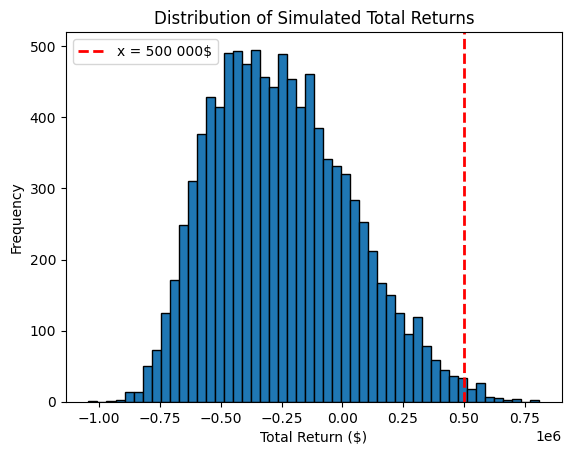

In [8]:
import matplotlib.pyplot as plt

#Set random seed for reproducibility
np.random.seed(12345)

#Number of simulations
n_simulations = 10000

#Cluster parameters (mean and std for interest and default rates, alpha and beta for loss fraction)
interest_params = [(0.1078, 0.0362),
                   (0.0932, 0.0274),
                   (0.1154, 0.0319),
                   (0.0824, 0.0206),
                   (0.1279, 0.0291)]

default_params = [(0.1019, 0.00766),
                  (0.1150, 0.00575),
                  (0.2147, 0.00877),
                  (0.1073, 0.00511),
                  (0.2833, 0.0073)]

loss_fraction_params = [(2.189, 1.153),
                        (1.787, 0.839),
                        (0.752, 0.347),
                        (1.948, 0.881),
                        (0.475, 0.219)]

investment_per_cluster = 2_000_000
n_clusters = 5

#Function to simulate returns for one simulation run given cluster parameters
def simulate_one_run():
    total_return = 0
    for i in range(n_clusters):
        mean_ir, std_ir = interest_params[i]
        # Calculate mu and sigma for lognormal
        mu = np.log((mean_ir**2) / np.sqrt(std_ir**2 + mean_ir**2))
        sigma = np.sqrt(np.log(1 + (std_ir**2 / mean_ir**2)))
        interest_rate = np.random.lognormal(mu, sigma)

        mean_def, std_def = default_params[i]
        default_rate = np.clip(np.random.normal(mean_def, std_def), 0, 0.3)

        alpha, beta = loss_fraction_params[i]
        loss_fraction = np.random.beta(alpha, beta)

        cluster_return = investment_per_cluster * ((1 - default_rate) * (1 + interest_rate) + default_rate * (1 - loss_fraction)) - investment_per_cluster
        total_return += cluster_return
   
    return total_return

#Run simulations
simulated_returns = np.array([simulate_one_run() for _ in range(n_simulations)])

#Calculate probability return exceeds $500,000
prob_exceed_500k = np.mean(simulated_returns > 500_000)
print(f"Probability that total return exceeds $500,000: {prob_exceed_500k:.4%}")

# Plot histogram of returns
plt.hist(simulated_returns, bins=50, edgecolor='k')
plt.axvline(x=500000, color='red', linestyle='--', linewidth=2, label='x = 500 000$')
plt.title("Distribution of Simulated Total Returns")
plt.xlabel("Total Return ($)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Optimization Model

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7527340321680186
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Optimal weights: [0.87 0.13 0.   0.   0.  ]
Expected NET return after 1 year: $268,027
Probability return exceeds $1M: 3.13%


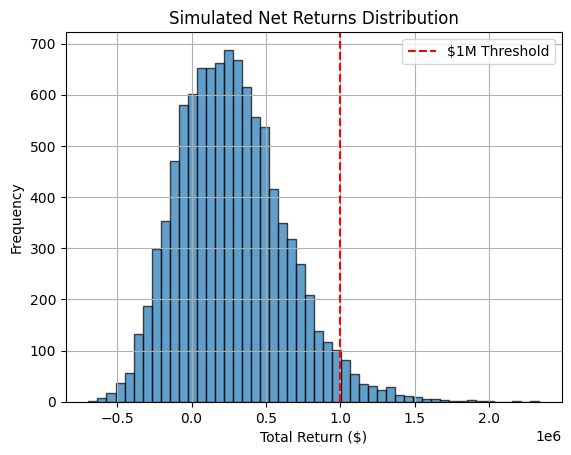

In [9]:
from scipy.optimize import minimize

#Cluster Parameters
interest_params = [(0.1078, 0.0362),
                   (0.0932, 0.0274),
                   (0.1154, 0.0319),
                   (0.0824, 0.0206),
                   (0.1279, 0.0291)]

default_params = [(0.1019, 0.00766),
                  (0.1150, 0.00575),
                  (0.2147, 0.00877),
                  (0.1073, 0.00511),
                  (0.2833, 0.0073)]

loss_fraction_params = [(2.189, 1.153),
                        (1.787, 0.839),
                        (0.752, 0.347),
                        (1.948, 0.881),
                        (0.475, 0.219)]

n_clusters = 5
n_simulations = 10_000
total_funds = 10_000_000

#Simulation function: simulate portfolio returns given weights
def simulate_returns(weights, seed=12345):
    np.random.seed(seed)  #Fix seed for reproducibility
    weights = np.array(weights)
    net_returns = []

    for _ in range(n_simulations):
        net_total_return = 0
        for i in range(n_clusters):
            #Interest rate: lognormal approx
            mean_ir, std_ir = interest_params[i]
            mu = np.log((mean_ir**2) / np.sqrt(std_ir**2 + mean_ir**2))
            sigma = np.sqrt(np.log(1 + (std_ir**2 / mean_ir**2)))
            r = np.random.lognormal(mu, sigma)

            #Default rate: normal clipped to [0, 1]
            mean_def, std_def = default_params[i]
            d = np.clip(np.random.normal(mean_def, std_def), 0, 1)

            #Loss fraction: beta distribution
            alpha, beta = loss_fraction_params[i]
            L = np.random.beta(alpha, beta)

            #Net return (relative)
            rel_net = ((1 - d) * (1 + r) + d * (1 - L)) - 1
            net_total_return += weights[i] * rel_net

        net_returns.append(net_total_return)

    return np.array(net_returns)

#Objective function: negative Sharpe ratio (to maximize Sharpe)
def negative_sharpe_ratio(weights):
    net_returns = simulate_returns(weights)
    mean_ret = np.mean(net_returns)
    std_ret = np.std(net_returns)
    if std_ret == 0:
        return np.inf
    sharpe = mean_ret / std_ret
    return -sharpe

#Initial equal allocation
initial_weights = [1 / n_clusters] * n_clusters

#Bounds: weights between 0 and 1
bounds = [(0, 1)] * n_clusters

#Constraint: sum(weights) == 1
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

#Run optimization
result = minimize(negative_sharpe_ratio,
                  initial_weights,
                  bounds=bounds,
                  constraints=constraints,
                  method='SLSQP',
                  options={'disp': True, 'maxiter': 1000, 'ftol': 1e-9})

optimal_weights = result.x
print("Optimal weights:", np.round(optimal_weights, 3))

#Final simulation with optimal weights
net_returns = simulate_returns(optimal_weights)
expected_total_net = np.mean(net_returns) * total_funds
prob_exceed_1M = np.mean(net_returns * total_funds > 1_000_000)

print(f"Expected NET return after 1 year: ${expected_total_net:,.0f}")
print(f"Probability return exceeds $1M: {prob_exceed_1M:.2%}")

#Plot histogram of net returns
plt.hist(net_returns * total_funds, bins=50, alpha=0.7, edgecolor='k')
plt.axvline(1_000_000, color='red', linestyle='--', label='$1M Threshold')
plt.title('Simulated Net Returns Distribution')
plt.xlabel('Total Return ($)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

### Note on Optimization Output

The current model successfully maximizes the Sharpe ratio and returns an expected net return within the target range. However, the probability of exceeding the $1,000,000 threshold remains below expectations.

At this stage, I acknowledge that the probability output is not yet aligned with the expected 18–20% range.

Further iterations will be explored to improve this aspect. This work remains in progress, and refinement will follow.